# Faster R-CNN in Pytorch with Example

In [1]:
import numpy as np
import io
import cv2
#from skimage.transform import resize
#from scipy.misc import resize
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os
import pandas as pd

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms



ModuleNotFoundError: No module named 'utils'

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [2]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = imread(img_path)
            #img = Image.open(img_path)
            #img = img.resize(self.img_size)
            img = np.stack([img] * 3, axis=-1)
            img = cv2.resize(img, (self.img_size), interpolation = cv2.INTER_LINEAR)
            #img = np.array(img)
            #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            
            #X.append(img_3d_resized)

            #X = np.array(X)

            # Normaliser les images
            #X = X / 255.0

            # Charger les images en noir et blanc en trois dimensions
            
            

            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            #print(img_tensor.shape)
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [3]:
img_width = 624
img_height = 624
annotation_path = "./pytorch-tutorials-master/pytorch-tutorials-master/Object Detection/Test data/nom_fichier.xml"
image_dir = os.path.join("./hackathon/Attachments/DB1/DB1/")
name2idx = {'pad': -1, 'default': 0, 'defaut': 1}
idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [4]:
load_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

In [5]:
old_dataloader = DataLoader(load_dataset, batch_size=2)

#### Grab a batch for demonstration

In [6]:
for img_batch, gt_bboxes_batch, gt_classes_batch in old_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

In [7]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

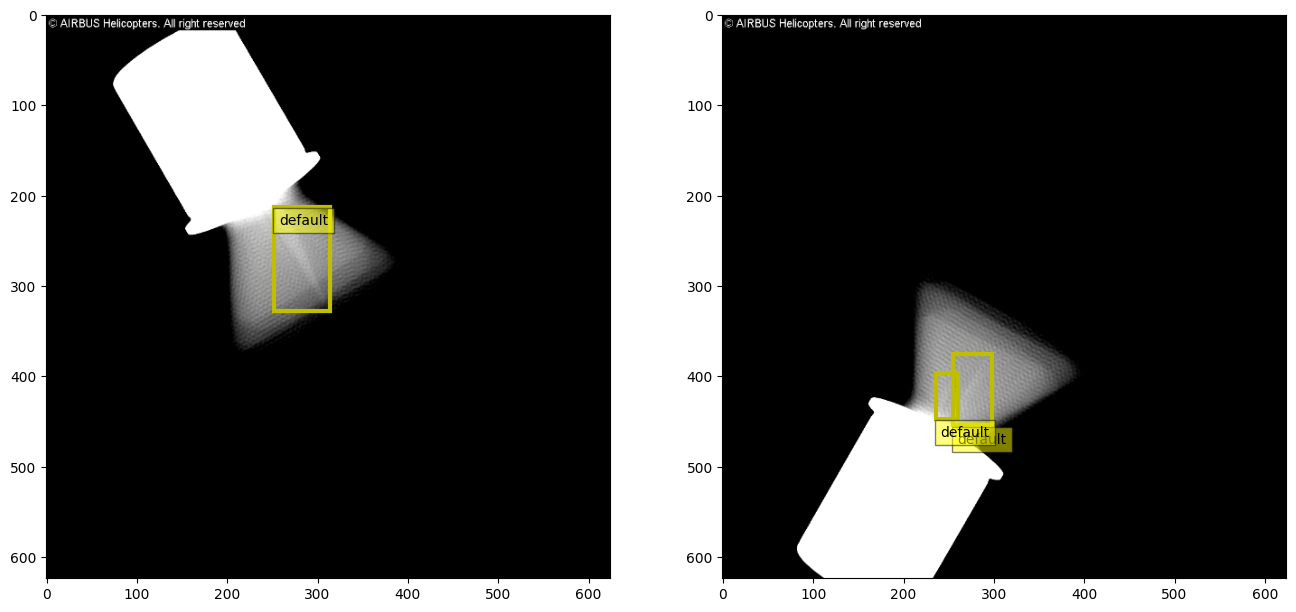

In [8]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [9]:
model = torchvision.models.resnet50(pretrained=True)

/home/amos-constant-junior/anaconda3/envs/hackathonEnv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amos-constant-junior/anaconda3/envs/hackathonEnv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [11]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True


# run the image through the backbone
out = backbone(img_data_all)

In [12]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

(2048, 20, 20)

#### Check how much the image has been down-scaled

In [13]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(31, 31)

### Visualize feature maps

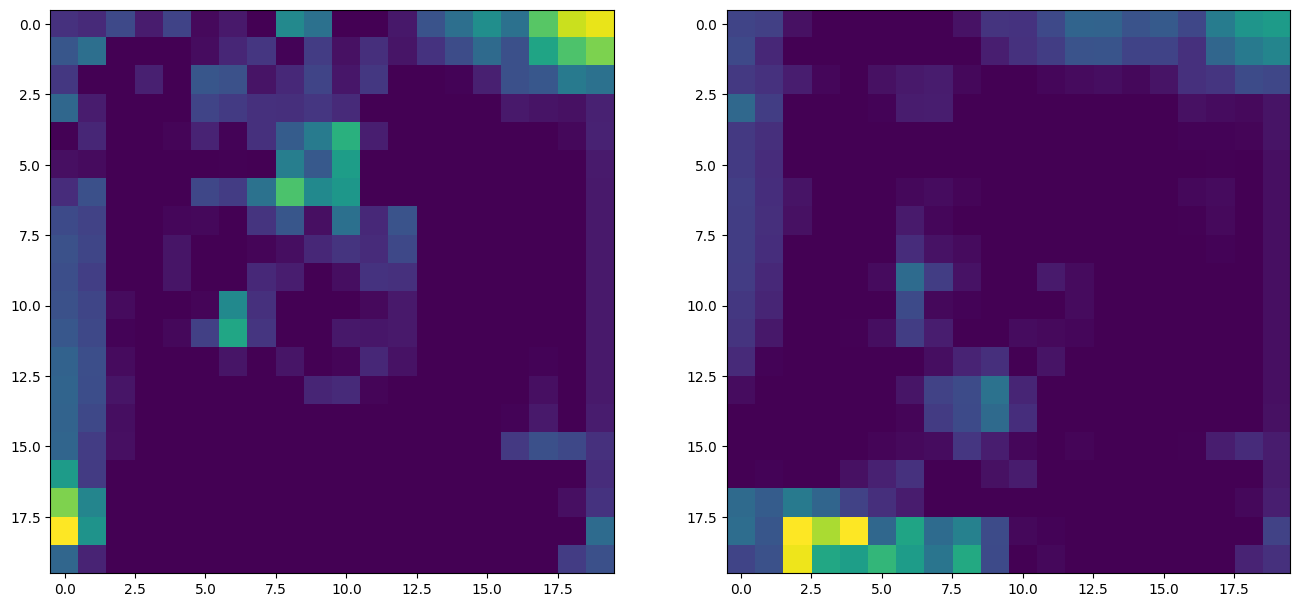

In [14]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [15]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [16]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

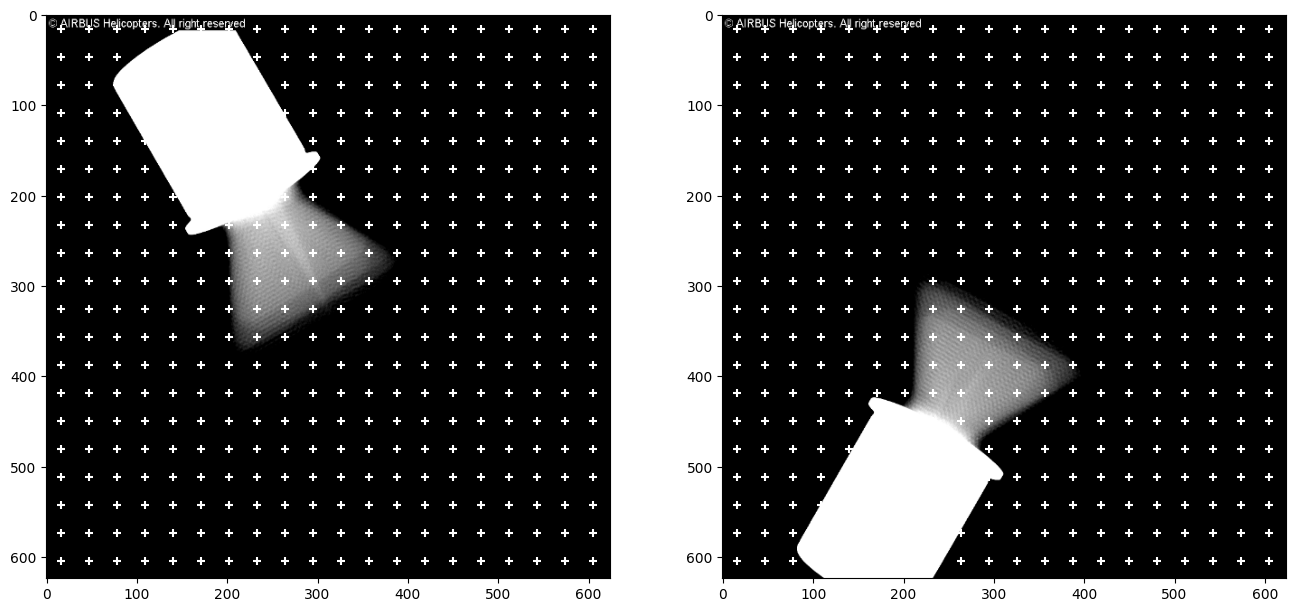

In [17]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

### Create Anchor Boxes around Anchor points

In [18]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [19]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

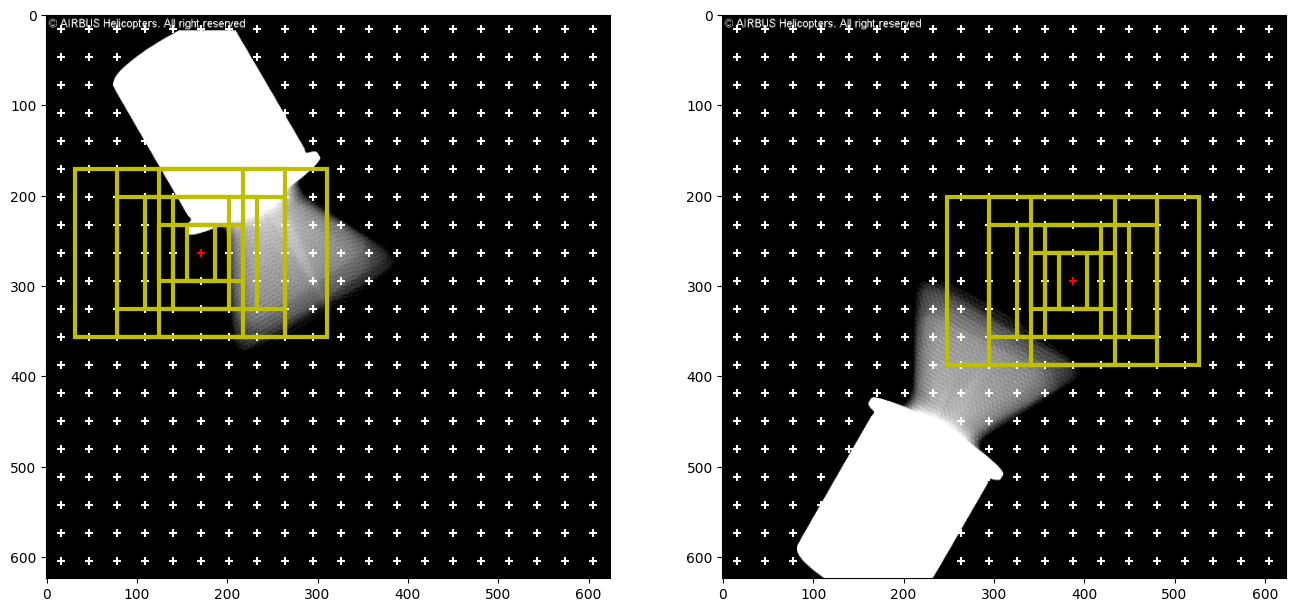

In [20]:
# nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# # project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# # plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

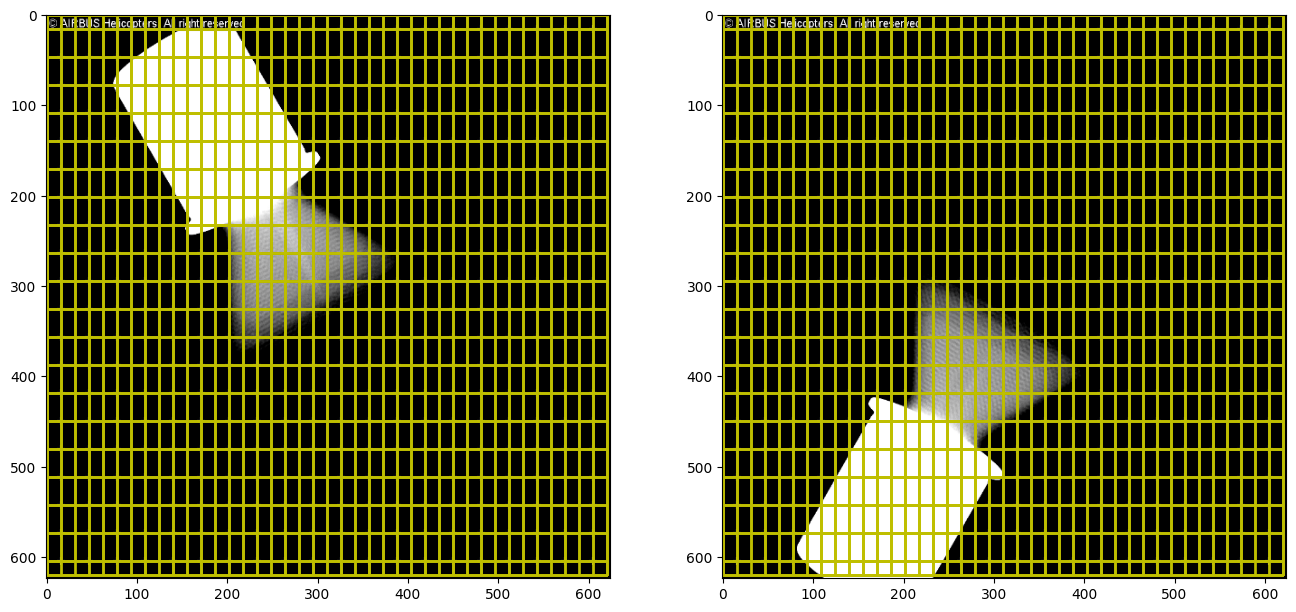

In [21]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [22]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [23]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

In [24]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

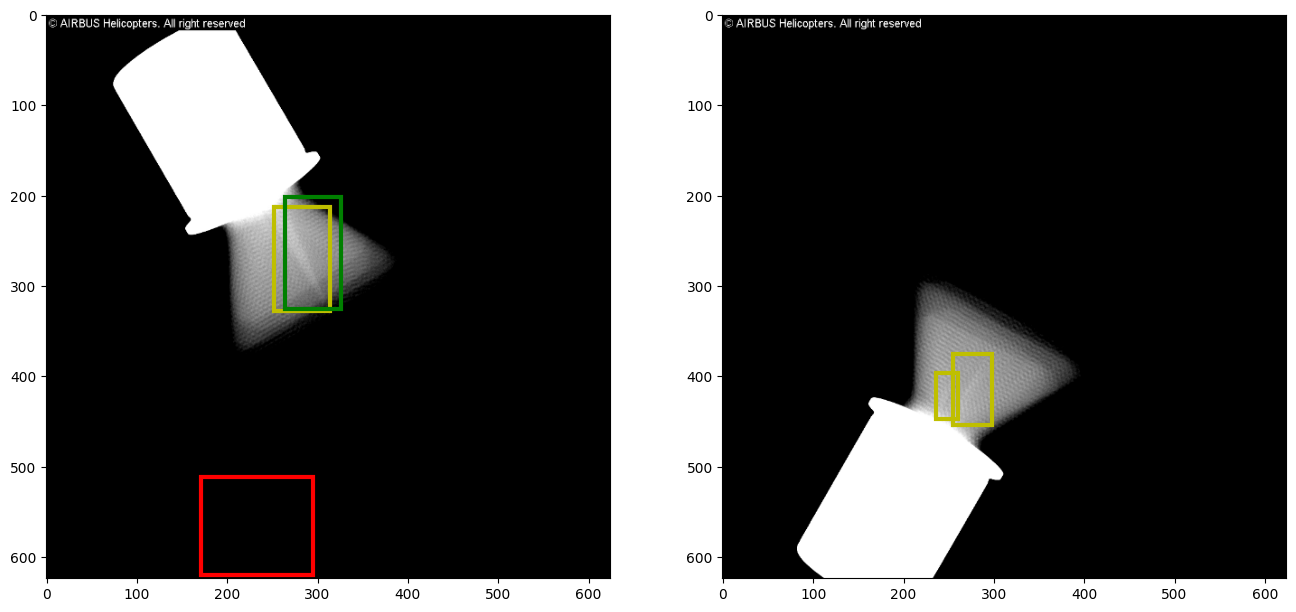

In [25]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

### Building the model

In [26]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [27]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

torch.Size([1, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])


### Training loop

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [ ]:
learning_rate = 1e-1
n_epochs = 25

loss_list = training_loop(detector, learning_rate, old_dataloader, n_epochs)

In [ ]:
plt.plot(loss_list)

### Load Model for predict 

In [28]:
'''
Chargement et initialisation du model 
'''

model_load = TwoStageDetector(img_size, out_size, 2048, n_classes, roi_size)
model_load.load_state_dict(torch.load("./model_007.pt"))
model_load.eval()

TwoStageDetector(
  (rpn): RegionProposalNetwork(
    (feature_extractor): FeatureExtractor(
      (backbone): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.

### Preprocessing for the image input

In [29]:
'''
Cette fonction prend en entrer le chemin du dossier d'image et obtient leur image_batch dans une liste associer a leur nom 
'''
def preprocess_images_all(directory):
    # Define the transform to resize the image and convert it to a tensor
    transform = transforms.Compose([
        transforms.Resize((624, 624)),
        transforms.ToTensor()
    ])

    # Create an empty list to store the preprocessed image tensors
    image_tensors = []
    nameForImage =[]
    batch_img_all = []

    # Iterate over all image files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Load the image and preprocess it
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path).convert('RGB')
            nameForImage.append(filename)

    # Apply the transform to the image
            image_tensor = transform(image)

    # Normalize the pixel values based on the mean and standard deviation of the dataset
            image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])(image_tensor)
            image_batch = image_tensor.unsqueeze(0)

            # Add the preprocessed image tensor to the list
            image_tensors.append(image_batch)

            batch_img_all.extend([nameForImage,image_tensors])

    return batch_img_all

In [30]:
'''
Le chemin de preprocessing des images
'''
all_image_batch =  preprocess_images_all('./hackathon/Attachments/DB2/DB2/')

In [38]:


'''
Fonction permettant detecter  les coordonnées des anomalies'''
def prediction_Image(model, image_batch_):
    images_proposals = []
    proposals_final_img = []
    conf_scores_final_img = []
    classes_final_img = []
    for i in range(len(image_batch_)):
        proposals, conf_scores, classes = model.inference(image_batch_[i], conf_thresh=0.99, nms_thresh=0.05)
        proposals_final_img.append(proposals)
        conf_scores_final_img.append(conf_scores)
        classes_final_img.append(classes)
        images_proposals.extend([proposals, conf_scores, classes])
    return images_proposals

all_anomaly_resolve = prediction_Image(model_load,all_image_batch[1])

torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size([3600, 4])
torch.Size

In [32]:
# Création de la dataset  

file_name = all_image_batch[0]
coordonnate =all_anomaly_resolve
data = list(zip(file_name, coordonnate))

# create a dataframe from the data
df = pd.DataFrame(data, columns=['File_name', 'Coordonnate'])

# Enregistrement de la dataframe en fichier csv
df.to_csv('Coordonnes_anomaly.csv', index=False)


In [37]:
prop_proj_1_img = project_bboxes(all_anomaly_resolve[0][0], width_scale_factor, height_scale_factor, mode='a2p')
# Creation des class 
# classes_pred_1_img = [idx2name[cls] for cls in all_anomaly_resolve[0][2].tolist()]

In [ ]:


# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# fig, axes = display_img(all_anomaly_resolve[0], fig, axes)
# fig, _ = display_bbox(prop_proj_1_img, fig, axes[0], classes=classes_pred_1_img)
